# Build a full catalogue of datasets

While there is an [official catalogue of all surveys](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/124049), 
there is no way to download all files in one go. 
I had to manually download the metadata records (ID, title, file location) for the surveys in batches of 100 (the maximum the website permitted). This lead to 16 CSV files with the information I need.  

This notebook builds a unified catalogue of survey IDs, titles, and download links. It will also query the server and try to figure out the disk space required for the surveys.

In [1]:
import glob
import pandas as pd
import requests
import matplotlib.pyplot as plt
from tqdm import tqdm

## Combine the metadata records

Read in all downloaded records and combine them into a single DataFrame.

In [2]:
tmp = []
for fname in glob.glob("../metadata/metadata_records*.csv"):
    print(f"Reading file: {fname}")
    tmp.append(pd.read_csv(fname, header=0, escapechar='\\', encoding='utf-8'))
catalogue = pd.concat(tmp)
print(f"\nUnique entries in the catalogue: {catalogue.uuid.unique().size}")

Reading file: ../metadata/metadata_records(13).csv
Reading file: ../metadata/metadata_records.csv
Reading file: ../metadata/metadata_records(12).csv
Reading file: ../metadata/metadata_records(15).csv
Reading file: ../metadata/metadata_records(4).csv
Reading file: ../metadata/metadata_records(14).csv
Reading file: ../metadata/metadata_records(1).csv
Reading file: ../metadata/metadata_records(11).csv
Reading file: ../metadata/metadata_records(16).csv
Reading file: ../metadata/metadata_records(5).csv
Reading file: ../metadata/metadata_records(9).csv
Reading file: ../metadata/metadata_records(8).csv
Reading file: ../metadata/metadata_records(3).csv
Reading file: ../metadata/metadata_records(7).csv
Reading file: ../metadata/metadata_records(6).csv
Reading file: ../metadata/metadata_records(2).csv
Reading file: ../metadata/metadata_records(10).csv

Unique entries in the catalogue: 1631


In [3]:
catalogue.head()

,uuid,eCatId,Title,Abstract,MetadataScope,ParentMetadata,CitationDate,Purpose,Status,Keyword,...,DataStorageLink,Lineage,SourceDescription,ServiceType,CouplingType,OperationName,DistributedComputingPlatform,OperationDescription,DistributionFormat,AssociatedResourcesLink
0,beeb5189-9f86-4961-8621-f162767ec418,124479,"Alton Downs Gravity (P196240), gravity point data",Gravity data measures small changes in gravity...,"dataset~Alton Downs Gravity (P196240), gravity...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Alton Downs Gravity (P196240), gravity po...","This Alton Downs Gravity (P196240), gravity po...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ef420cf3-f391-4d10-bfe6-bdae88b5f7f6,124509,"Dalhousie Gravity 1963D9 (P196340), gravity po...",Gravity data measures small changes in gravity...,"dataset~Dalhousie Gravity 1963D9 (P196340), gr...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Dalhousie Gravity 1963D9 (P196340), gravi...","This Dalhousie Gravity 1963D9 (P196340), gravi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bb919033-23b3-44c9-9a07-60755a6e7141,124488,"Helicopter Gravity (Contract) (P196304), gravi...",Gravity data measures small changes in gravity...,dataset~Helicopter Gravity (Contract) (P196304...,NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Helicopter Gravity (Contract) (P196304), ...","This Helicopter Gravity (Contract) (P196304), ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0d8c4584-07e0-4fa2-8b7a-699dcb2af3da,124464,"Renmark, Pata, Wanbi Gravity (P196163), gravit...",Gravity data measures small changes in gravity...,"dataset~Renmark, Pata, Wanbi Gravity (P196163)...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Renmark, Pata, Wanbi Gravity (P196163), g...","This Renmark, Pata, Wanbi Gravity (P196163), g...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60bc1b84-59d7-4ecf-a11d-e48f4a6a9ae8,124513,"Augusta Moora Gravity (P196346), gravity point...",Gravity data measures small changes in gravity...,"dataset~Augusta Moora Gravity (P196346), gravi...",NaN,2018-07-13T00:00:00~creation###2018-07-13T00:0...,NaN,completed,NCI~dataCentre###Earth sciences~discipline###g...,...,/g/data/iv65/Geoscience_Australia_Geophysics_R...,"This Augusta Moora Gravity (P196346), gravity ...","This Augusta Moora Gravity (P196346), gravity ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's have a look at what we got.

In [4]:
catalogue.columns

Index(['uuid', 'eCatId', 'Title', 'Abstract', 'MetadataScope',
       'ParentMetadata', 'CitationDate', 'Purpose', 'Status', 'Keyword',
       'Keyword-Thesaurus', 'TopicCategory', 'MaintenanceFrequency',
       'ResponsibleParty', 'ResourceContact', 'MetadataContact',
       'GeographicalExtent', 'SpatialExtentDescription',
       'HorizontalSpatialReferenceSystem', 'VerticalExtent', 'VerticalCRS',
       'TemporalExtent', 'ResourceLegalConstraints', 'UseLimitations',
       'DistributionLink', 'DataStorageLink', 'Lineage', 'SourceDescription',
       'ServiceType', 'CouplingType', 'OperationName',
       'DistributedComputingPlatform', 'OperationDescription',
       'DistributionFormat', 'AssociatedResourcesLink'],
      dtype='object')

Check the horizontal datum. Most should be in GDA94.

In [5]:
print(catalogue.HorizontalSpatialReferenceSystem.unique())
print(catalogue.HorizontalSpatialReferenceSystem.describe())

['GDA94 (EPSG:4283)' 'WGS 84 (geocentric) (EPSG:4328)']
count                  1631
unique                    2
top       GDA94 (EPSG:4283)
freq                   1624
Name: HorizontalSpatialReferenceSystem, dtype: object


No information on the vertical datum... But I think the individual datasets have this information.

In [6]:
print(catalogue.VerticalCRS.unique())
print(catalogue.VerticalCRS.describe())

[nan]
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: VerticalCRS, dtype: float64


## Create and check the download links

Make sure they all follow the same format. See the HTTP download link for the THREDDS server below. We can generate that link from the `DataStorageLink` column.

In [7]:
print(catalogue.DistributionLink.values[0])

File available for download in various formats from the GADDS2 portal~The Geophysical Archive Data Delivery System (GADDS2) portal provides HTTP download of geophysics datasets in a number of formats. Point and line datasets are available in NetCDF and ASEG-GDF2. Grid datasets are available in NetCDF, GeoTIFF and ERS.~https://portal.ga.gov.au/persona/gadds###/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/ground_gravity/GA/point/P196240/P196240-point-gravity.nc file at NCI~Fully qualified pathname of NetCDF file on NCI filesystem for Alton Downs Gravity (P196240), gravity point data. Users must be logged onto the NCI network to access this file system.~file://iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/ground_gravity/GA/point/P196240/P196240-point-gravity.nc###/g/data/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/ground_gravity/GA/point/P196240/P196240-point-gravity.nc file download~File download for Alton Downs Gravity (P19624

In [8]:
baseurl = "http://dapds00.nci.org.au/thredds/fileServer/"

In [9]:
catalogue["DownloadLink"] = (baseurl + catalogue.DataStorageLink.str[8:]).astype(str)
catalogue.DownloadLink.values[0]

'http://dapds00.nci.org.au/thredds/fileServer/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/ground_gravity/GA/point/P196240/P196240-point-gravity.nc'

Check if any of links does not point to a netCDF file (`*.nc`). These will cause trouble during the download.

In [10]:
not_nc = ~catalogue.DataStorageLink.str.endswith(".nc")
invalid_storage_link = catalogue.loc[not_nc, :]
invalid_storage_link

,uuid,eCatId,Title,Abstract,MetadataScope,ParentMetadata,CitationDate,Purpose,Status,Keyword,...,Lineage,SourceDescription,ServiceType,CouplingType,OperationName,DistributedComputingPlatform,OperationDescription,DistributionFormat,AssociatedResourcesLink,DownloadLink
0,9def650e-7c46-4ebe-82a5-f8836b61b96b,125926,Gravity point located data of Australia Wide A...,Gravity data measures small changes in gravity...,dataset~dataset~dataset,124049.0,2012-10-03T00:00:00~publication###2018-12-19T0...,NaN,NaN,Australia~place###All States~place###survey 20...,...,This Australia Wide Absolute AFGN Survey 2012 ...,This P201299_GNDGRAV.nc dataset contains groun...,NaN,NaN,NaN,NaN,NaN,NetCDF~1###html~1###NetCDF~1###html~1,~Link to eCat metadata record landing page~htt...,http://dapds00.nci.org.au/thredds/fileServer/g...
2,0f5d2015-6bc4-42ec-8a0f-d6962b8a3387,124568,Gravity point located data of Australia Wide I...,Gravity data measures small changes in gravity...,dataset~dataset~dataset,124049.0,2001-06-07T00:00:00~publication###2018-12-19T0...,NaN,NaN,Australia~place###All states~place###Earth sci...,...,This Australia Wide Isogal dataset release con...,This P196500_GNDGRAV.nc dataset contains groun...,NaN,NaN,NaN,NaN,NaN,NetCDF~1###html~1###NetCDF~1###html~1,~Link to eCat metadata record landing page~htt...,http://dapds00.nci.org.au/thredds/fileServer/g...
12,d7dc1762-1c4a-42cc-830c-82e932703fef,124540,Gravity point located data of Australia Wide G...,Gravity data measures small changes in gravity...,dataset~dataset~dataset,124049.0,2001-06-07T00:00:00~publication###2018-12-19T0...,NaN,NaN,point~featureType###survey 196410~project###Au...,...,This Australia Wide Grav dataset release conta...,This P196410_GNDGRAV.nc dataset contains groun...,NaN,NaN,NaN,NaN,NaN,NetCDF~1###html~1###NetCDF~1###html~1,~Link to eCat metadata record landing page~htt...,http://dapds00.nci.org.au/thredds/fileServer/g...
17,e5dcf7e0-c092-4bd4-98cc-1546d36ba8c4,125870,Gravity point located data of Australia Wide A...,Gravity data measures small changes in gravity...,dataset~dataset~dataset,124049.0,2008-02-08T00:00:00~publication###2018-12-19T0...,NaN,NaN,NCI~dataCentre###Australia~place###point~featu...,...,This Australia Wide Absolute Gravity Readings ...,This P200799_GNDGRAV.nc dataset contains groun...,NaN,NaN,NaN,NaN,NaN,NetCDF~1###html~1###NetCDF~1###html~1,~Link to eCat metadata record landing page~htt...,http://dapds00.nci.org.au/thredds/fileServer/g...
21,5f2f04db-09f3-442d-a7f5-02ef83432756,125962,Gravity point located data of Australia Wide A...,Gravity data measures small changes in gravity...,dataset~dataset~dataset,124049.0,2017-02-01T00:00:00~publication###2018-12-19T0...,NaN,NaN,point~featureType###survey 201691~project###gr...,...,This Australia Wide AFGN Absolute 2016 dataset...,This P201691_GNDGRAV.nc dataset contains groun...,NaN,NaN,NaN,NaN,NaN,NetCDF~1###html~1###NetCDF~1###html~1,~Link to eCat metadata record landing page~htt...,http://dapds00.nci.org.au/thredds/fileServer/g...
22,cdce3d42-870c-4cb9-8078-bbe6099a7beb,125940,Gravity point located data of Australia wide A...,Gravity data measures small changes in gravity...,dataset~dataset~dataset,124049.0,2013-08-21T00:00:00~publication###2018-12-19T0...,NaN,NaN,survey 201391~project###point~featureType###NC...,...,This Australia wide AFGN Absolute 2013 dataset...,This P201391_GNDGRAV.nc dataset contains groun...,NaN,NaN,NaN,NaN,NaN,NetCDF~1###html~1###NetCDF~1###html~1,~Link to eCat metadata record landing page~htt...,http://dapds00.nci.org.au/thredds/fileServer/g...
29,bbb5c0bd-3fa7-47f7-b01d-f5c917eedb32,125957,Gravity point located data of Australia Wide A...,Gravity data measures small changes in gravity...,dataset~dataset~dataset,124049.0,2015-07-22T00:00:00~publication###2018-12-19T0...,NaN,NaN,Earth sciences~discipline###geophysics~discipl...,...,This Australia Wide AFGN Absolute 2015 dataset...,This P201590_GNDGRAV.nc dataset contains groun...,NaN,NaN,NaN,NaN,NaN,NetCDF~1###html~1###Ne

Let's see what the link and distribution information look like for these entries.

In [11]:
for i, row in invalid_storage_link.iterrows():
    print("Link:", row.DataStorageLink)
    print("ID:", row.uuid)
    print("Info:", row.DistributionLink)

Link: file:///g/data1/rr2/ground_gravity/Commonwealth/P201299/points/P201299_GNDGRAV
ID: 9def650e-7c46-4ebe-82a5-f8836b61b96b
Info: nan
Link: file:///g/data1/rr2/ground_gravity/Commonwealth/P196500/points/P196500_GNDGRAV
ID: 0f5d2015-6bc4-42ec-8a0f-d6962b8a3387
Info: nan
Link: file:///g/data1/rr2/ground_gravity/Commonwealth/P196410/points/P196410_GNDGRAV
ID: d7dc1762-1c4a-42cc-830c-82e932703fef
Info: nan
Link: file:///g/data1/rr2/ground_gravity/Commonwealth/P200799/points/P200799_GNDGRAV
ID: e5dcf7e0-c092-4bd4-98cc-1546d36ba8c4
Info: nan
Link: file:///g/data1/rr2/ground_gravity/Commonwealth/P201691/points/P201691_GNDGRAV
ID: 5f2f04db-09f3-442d-a7f5-02ef83432756
Info: nan
Link: file:///g/data1/rr2/ground_gravity/Commonwealth/P201391/points/P201391_GNDGRAV
ID: cdce3d42-870c-4cb9-8078-bbe6099a7beb
Info: nan
Link: file:///g/data1/rr2/ground_gravity/Commonwealth/P201590/points/P201590_GNDGRAV
ID: bbb5c0bd-3fa7-47f7-b01d-f5c917eedb32
Info: nan


No luck there with the missing info. But searching the catalogue for the ID led me to the [actual THREDDS catalogue entry](http://dapds00.nci.org.au/thredds/catalog/rr2/ground_gravity/Commonwealth/P201299/points/P201299_GNDGRAV/catalog.html?dataset=rr2-Ground_Gravity/Commonwealth/P201299/points/P201299_GNDGRAV/P201299_GNDGRAV.nc) which has this link:

http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P201299/points/P201299_GNDGRAV/P201299_GNDGRAV.nc

So the base URL is the same but the way to format those entries is slightly different.

In [12]:
catalogue.loc[not_nc, "DownloadLink"] = (
    baseurl 
    + invalid_storage_link.DataStorageLink.str[16:] 
    + "/"
    + invalid_storage_link.DataStorageLink.str.split("/", expand=True).iloc[:, -1]
    + ".nc"
)

In [13]:
for i, row in catalogue[not_nc].iterrows():
    print("Link:", row.DownloadLink)

Link: http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P201299/points/P201299_GNDGRAV/P201299_GNDGRAV.nc
Link: http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P196500/points/P196500_GNDGRAV/P196500_GNDGRAV.nc
Link: http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P196410/points/P196410_GNDGRAV/P196410_GNDGRAV.nc
Link: http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P200799/points/P200799_GNDGRAV/P200799_GNDGRAV.nc
Link: http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P201691/points/P201691_GNDGRAV/P201691_GNDGRAV.nc
Link: http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P201391/points/P201391_GNDGRAV/P201391_GNDGRAV.nc
Link: http://dapds00.nci.org.au/thredds/fileServer/rr2/ground_gravity/Commonwealth/P201590/points/P201590_GNDGRAV/P201590_GNDGRAV.nc


Make sure the download links are unique and we haven't messed anything up.

In [14]:
catalogue.DownloadLink.unique().size == catalogue.shape[0]

True

## Get the download size of each survey

It would be nice to know the size of these datasets before we actually download them. We can do that with a GET request, which also lets us check if the link is valid.

In [15]:
nbytes = []
failed = []
for i, url in enumerate(tqdm(catalogue.DownloadLink.values, ncols=100)):
    response = requests.get(url, stream=True)
    # Keep track of any failed requests
    if response.status_code != 200:
        failed.append((i, url))
    nbytes.append(int(response.headers["Content-length"]))

100%|███████████████████████████████████████████████████████████| 1631/1631 [21:32<00:00,  1.26it/s]


In [16]:
print(failed)

[]


Add the size information to the catalogue.

In [17]:
catalogue["SizeBytes"] = nbytes

Plot the distribution of file sizes.

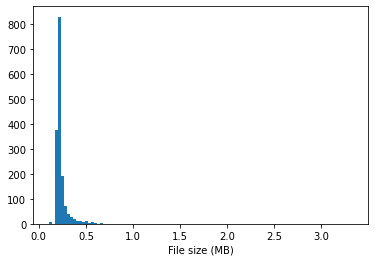

In [18]:
plt.figure()
plt.hist(catalogue.SizeBytes * 1e-6, bins=100)
plt.xlabel("File size (MB)")
plt.show()

Calculate the total size.

In [19]:
print(f"Total download size: {catalogue.SizeBytes.sum() * 1e-6} MB")

Total download size: 388.090011 MB


## Export to CSV

In [20]:
catalogue.to_csv("../metadata/records.csv", index=False)